In [37]:
from keras.layers.core import Activation, Dense, Dropout
from keras.layers import concatenate,Reshape,Add,LSTM,Multiply
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential,Model
from keras import Model
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras import Input
import keras
import numpy as np
import multiprocessing
import collections
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.preprocessing.text import text_to_word_sequence
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import string
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from time import time
from gensim.models import Word2Vec
#nltk.download('punkt')
#nltk.download('stopwords')


In [2]:
data=np.array(pd.read_csv('data.csv'))

In [3]:
data[45]

array(['2004-01-04', 'capricorn',
       'Не будьте слишком настойчивы, побольше оригинальности в поступках. Дело, запланированное на сегодня, успешно завершится, а его плоды вы начнете собирать в скором будущем.'],
      dtype=object)

In [4]:
russian_stopwords = ['и', 'в', 'а', 'с', 'но', 'у', 'я', 'же'] #укороченная последовательность стопслов
#russian_stopwords = set(stopwords.words('russian')) #результат может ухудшаться
print(russian_stopwords)

['и', 'в', 'а', 'с', 'но', 'у', 'я', 'же']


#### Разобьем каждое предложение на токены

In [16]:
def processText(data):
    tokens=[]
    for line in data:
        newToken=text_to_word_sequence(text=line[2],filters='!"#$%&amp;()*+,-./:;&lt;=>?@[\\]^_`{|}~\t\n\ufeff',
                                  lower=True,split=' ')
        tokens.append(newToken)
    return tokens

In [19]:
tokens=processText(data)
print(tokens[:2])

[['любые', 'разногласия', 'во', 'мнениях', 'скоро', 'улягутся', 'а', 'вы', 'продолжайте', 'делать', 'как', 'делали', 'но', 'постарайтесь', 'не', 'наступать', 'на', 'ноги', 'слишком', 'многим', 'иначе', 'ваши', 'сегодняшние', 'действия', 'сыграют', 'против', 'вас', 'в', 'будущем'], ['первый', 'день', 'нового', 'года', 'прекрасно', 'подходит', 'для', 'начинаний', 'которые', 'вы', 'постоянно', 'откладывали', 'в', 'прошлом', 'году', 'отбросьте', 'все', 'сомнения', 'и', 'действуйте', 'упор', 'может', 'быть', 'сделан', 'как', 'на', 'повышение', 'профессиональной', 'квалификации', 'так', 'и', 'на', 'реформацию', 'личной', 'жизни']]


Создадим слой embedding, обучив модель Word2Vec на своих данных.

In [125]:
embeddingDim=100
cores = multiprocessing.cpu_count() 
w2v_model = Word2Vec(min_count=1,
                     window=5,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-2)

In [123]:
words=list(w2v.wv.vocab)
print(words[:10])

['любые', 'разногласия', 'во', 'мнениях', 'скоро', 'улягутся', 'а', 'вы', 'продолжайте', 'делать']


In [127]:
t = time()

w2v_model.build_vocab(sentences=tokens, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.22 mins


In [128]:
t=time()

w2v_model.train(sentences=tokens, total_examples=w2v_model.corpus_count, epochs=400, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

w2v_model.save("word2vec.model")

Time to train the model: 23.39 mins


In [41]:
#w2v_model.save("word2vec.model")

In [130]:
w2v = Word2Vec.load("word2vec.model")

In [131]:
w2v.wv.most_similar(positive=["весы"])

[('девы', 0.7528153657913208),
 ('раки', 0.7447417974472046),
 ('водолеи', 0.7439862489700317),
 ('скорпионы', 0.7434227466583252),
 ('львы', 0.7415359020233154),
 ('тельцы', 0.7390024662017822),
 ('близнецы', 0.7383283376693726),
 ('рыбы', 0.7275119423866272),
 ('стрельцы', 0.7106574177742004),
 ('овны', 0.708452582359314)]

In [55]:
w2v.wv.most_similar(positive=["весы"])

[('водолеи', 0.8072859048843384),
 ('тельцы', 0.8061671257019043),
 ('близнецы', 0.8014423847198486),
 ('девы', 0.7937147617340088),
 ('раки', 0.7924394607543945),
 ('рыбы', 0.7856960296630859),
 ('овны', 0.7791558504104614),
 ('львы', 0.7754101157188416),
 ('козероги', 0.771586537361145),
 ('стрельцы', 0.7705822587013245)]

In [53]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [132]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=12).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

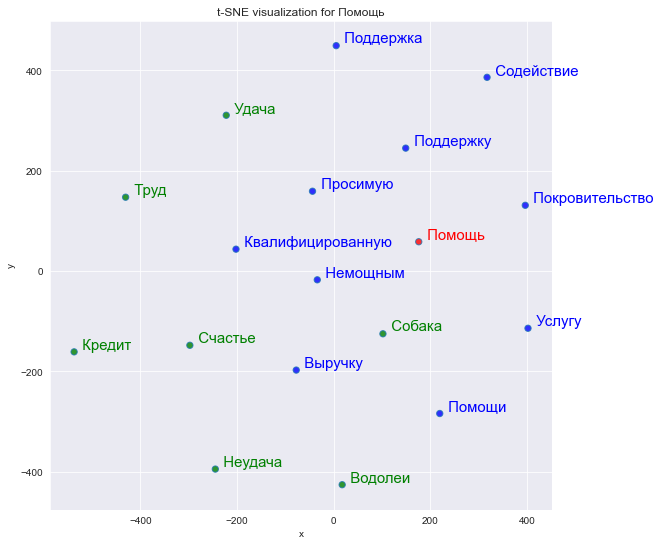

In [156]:
tsnescatterplot(w2v_model, 'помощь', ['водолеи','неудача','удача', 'собака','труд','кредит','счастье'])

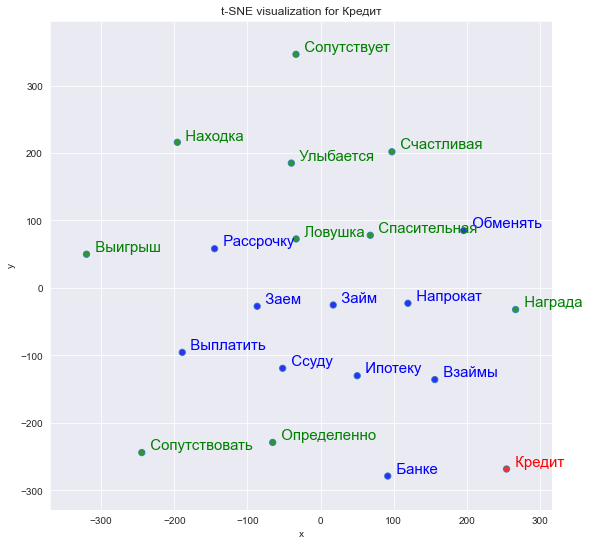

In [121]:
tsnescatterplot(w2v_model,"кредит", [t[0] for t in w2v_model.wv.most_similar(positive=["удача"], topn=20)][10:])

In [72]:
w2v_model['любые'][:10]

C:\Users\Администратор\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 1.2225144 ,  1.0179412 , -0.99135494,  1.9261177 , -1.511971  ,
       -0.15958996,  1.9277831 ,  0.05305602, -0.6931883 ,  0.522056  ],
      dtype=float32)